In [ ]:
  # Install specific libraries
! pip install transformers
! pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 16.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.

In [ ]:
import numpy as np
import pandas as pd
import pycaret
from transformers import AutoModel, AutoTokenizer
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn

# specify GPU
device = torch.device("cuda")

In [ ]:
# Mount Google Drive - applicable, if working on Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set Working Directory - if working on Google Drive
%cd /content/drive/MyDrive/BERT

# # Set Working Directory - if working on Local Machine
# import os
# os.chdir('/Users//replace_me')

/content/drive/MyDrive/BERT


In [ ]:
# Load Dataset
true_data = pd.read_csv('true2.csv')
fake_data = pd.read_csv('fake2.csv')

# Generate labels True/Fake under new Target Column in 'true_data' and 'fake_data'
true_data['Target'] = ['True']*len(true_data)
fake_data['Target'] = ['Fake']*len(fake_data)

# Merge 'true_data' and 'fake_data', by random mixing into a single df called 'data'
data = pd.concat([true_data,fake_data]).sample(frac=1).reset_index().drop(columns=['index'])

# See how the data looks like
print(data.shape)
data.head()

(44898, 5)


,title,text,subject,date,Target
0,Turkey says hopes U.S. will lift decision on v...,ANKARA (Reuters) - Turkey hopes the United Sta...,worldnews,"October 11, 2017",True
1,People Are Going To LOSE IT When They Discove...,This should come as a surprise to no one ever ...,News,"January 23, 2017",Fake
2,Afghanistan War Vet Humiliates Republican Opp...,Thinking before you speak is basically a requi...,News,"June 21, 2016",Fake
3,"Trump says open to bilateral Canada, Mexico pa...",WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"October 11, 2017",True
4,NBC NEWS CHIEF Makes Ugly Confession About Deb...,NBC News chairman Andy Lack confessed to nervo...,politics,"Sep 20, 2017",Fake


In [ ]:
import pandas as pd

# Assuming 'data' is your DataFrame containing the 'Target' column
data['label'] = (data['Target'] == 'Fake').astype(int)


In [ ]:
data.head()

,title,text,subject,date,Target,label
0,Turkey says hopes U.S. will lift decision on v...,ANKARA (Reuters) - Turkey hopes the United Sta...,worldnews,"October 11, 2017",True,0
1,People Are Going To LOSE IT When They Discove...,This should come as a surprise to no one ever ...,News,"January 23, 2017",Fake,1
2,Afghanistan War Vet Humiliates Republican Opp...,Thinking before you speak is basically a requi...,News,"June 21, 2016",Fake,1
3,"Trump says open to bilateral Canada, Mexico pa...",WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"October 11, 2017",True,0
4,NBC NEWS CHIEF Makes Ugly Confession About Deb...,NBC News chairman Andy Lack confessed to nervo...,politics,"Sep 20, 2017",Fake,1


([<matplotlib.patches.Wedge at 0x7d9b30e9b190>,
 [Text(-1.1968727067385088, -0.0865778485782335, 'Fake'),
  Text(1.1968726986325005, 0.08657796063754254, 'True')],
 [Text(-0.6981757455974634, -0.05050374500396954, '52.3%'),
  Text(0.6981757408689586, 0.05050381037189981, '47.7%')])

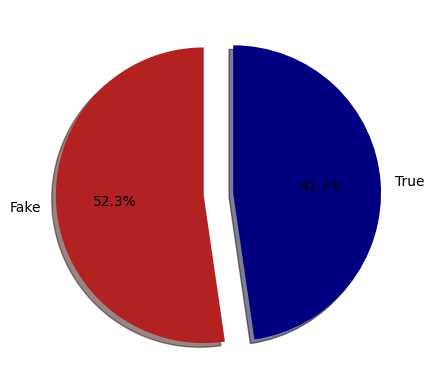

In [ ]:
# Checking if our data is well balanced
label_size = [data['label'].sum(),len(data['label'])-data['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')

In [ ]:
# Train-Validation-Test set split into 70:15:15 ratio
# Train-Temp split
train_text, temp_text, train_labels, temp_labels = train_test_split(data['title'], data['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=data['Target'])
# Validation-Test split
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

In [ ]:
from transformers import AutoModel, AutoTokenizer

# Load ALBERT model and tokenizer
albert_model = AutoModel.from_pretrained('albert-base-v2')
albert_tokenizer = AutoTokenizer.from_pretrained('albert-base-v2')


config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Text(0, 0.5, 'Number of texts')

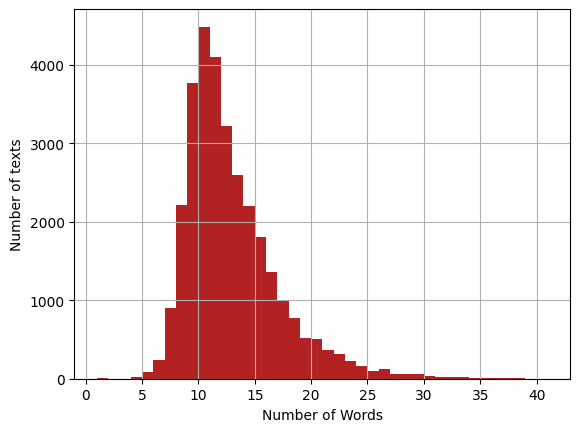

In [ ]:
# Plot histogram of the number of words in train data 'title'
seq_len = [len(title.split()) for title in train_text]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [ ]:
# ALBERT Tokenizer Functionality
sample_data = ["Build fake news model.",
               "Using ALBERT."]                                         # sample data
tokenized_sample_data = albert_tokenizer.batch_encode_plus(sample_data,
                                                            padding=True)     # encode text
print(tokenized_sample_data)


{'input_ids': [[2, 1895, 7031, 996, 1061, 9, 3], [2, 568, 2953, 9, 3, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 0, 0]]}


In [ ]:
# Majority of titles above have word length under 15. So, we set max title length as 15
MAX_LENGTH = 15

# Tokenize and encode sequences in the train set
tokens_train = albert_tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length=MAX_LENGTH,
    pad_to_max_length=True,
    truncation=True
)

# Tokenize and encode sequences in the validation set
tokens_val = albert_tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length=MAX_LENGTH,
    pad_to_max_length=True,
    truncation=True
)

# Tokenize and encode sequences in the test set
tokens_test = albert_tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length=MAX_LENGTH,
    pad_to_max_length=True,
    truncation=True
)


In [ ]:
# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32  # Define a batch size

# Define train DataLoader
train_data = TensorDataset(train_seq, train_mask, train_y)  # Wrap tensors
train_sampler = RandomSampler(train_data)  # Sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)  # DataLoader for train set

# Define validation DataLoader
val_data = TensorDataset(val_seq, val_mask, val_y)  # Wrap tensors
val_sampler = SequentialSampler(val_data)  # Sampler for sampling the data during validation
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)  # DataLoader for validation set


In [ ]:
for param in albert_model.parameters():
    param.requires_grad = False


In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch.nn as nn
from transformers import AdamW

# Load ALBERT model and tokenizer
albert_model = AutoModel.from_pretrained('albert-base-v2')
albert_tokenizer = AutoTokenizer.from_pretrained('albert-base-v2')

class ALBERT_Arch(nn.Module):
    def __init__(self, albert):
        super(ALBERT_Arch, self).__init__()
        self.albert = albert
        self.dropout = nn.Dropout(0.1)            # dropout layer
        self.relu =  nn.ReLU()                    # relu activation function
        self.fc1 = nn.Linear(768, 512)            # dense layer 1
        self.fc2 = nn.Linear(512, 2)              # dense layer 2 (Output layer)
        self.softmax = nn.LogSoftmax(dim=1)       # softmax activation function

    def forward(self, input_ids, attention_mask):
        output = self.albert(input_ids=input_ids, attention_mask=attention_mask)
        cls_hs = output['pooler_output']
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)                           # output layer
        x = self.softmax(x)                       # apply softmax activation
        return x

model = ALBERT_Arch(albert_model)

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Define the loss function
cross_entropy = nn.NLLLoss()

# Number of training epochs
epochs = 3


In [ ]:
import torch

def train(train_dataloader, model, optimizer, cross_entropy):
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        batch = [r.to(device) for r in batch]  # Push the batch to device
        sent_id, mask, labels = batch
        optimizer.zero_grad()  # Clear previously calculated gradients
        preds = model(sent_id, mask)  # Get model predictions for the current batch
        loss = cross_entropy(preds, labels)  # Compute loss between actual & predicted values
        total_loss += loss.item()  # Add to the total loss
        loss.backward()  # Backward pass to calculate gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Clip gradients to 1.0
        optimizer.step()  # Update parameters

    avg_loss = total_loss / len(train_dataloader)  # Compute training loss of the epoch
    return avg_loss


def evaluate(val_dataloader, model, cross_entropy):
    print("\nEvaluating...")
    model.eval()  # Deactivate dropout layers
    total_loss = 0
    for step, batch in enumerate(val_dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
        batch = [t.to(device) for t in batch]  # Push the batch to device
        sent_id, mask, labels = batch
        with torch.no_grad():  # Deactivate autograd
            preds = model(sent_id, mask)  # Model predictions
            loss = cross_entropy(preds, labels)  # Compute the validation loss
            total_loss += loss.item()

    avg_loss = total_loss / len(val_dataloader)  # Compute the validation loss of the epoch
    return avg_loss


In [ ]:
device = torch.device('cpu')

best_valid_loss = float('inf')  # Initialize best_valid_loss to positive infinity or any other suitable value
train_losses = []  # Initialize train_losses list
valid_losses = []  # Initialize valid_losses list

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss = train(train_dataloader, model, optimizer, cross_entropy)  # train model
    valid_loss = evaluate(val_dataloader, model, cross_entropy)  # evaluate model
    if valid_loss < best_valid_loss:  # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'albert_new_model_weights.pt')
    train_losses.append(train_loss)  # append training loss
    valid_losses.append(valid_loss)  # append validation loss

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')



 Epoch 1 / 3
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  Batch   650  of    983.
  Batch   700  of    983.
  Batch   750  of    983.
  Batch   800  of    983.
  Batch   850  of    983.
  Batch   900  of    983.
  Batch   950  of    983.

Evaluating...
  Batch    50  of    211.
  Batch   100  of    211.
  Batch   150  of    211.
  Batch   200  of    211.

Training Loss: 0.155
Validation Loss: 0.087

 Epoch 2 / 3
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  

In [ ]:
import torch

# Assuming you have previously defined and trained your model
# model = YourModelClass(...)

# Assuming test_seq and test_mask are your test data sequences and masks
with torch.no_grad():
    preds = model(test_seq, test_mask)
    preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis=1)
print(classification_report(test_y, preds))


              precision    recall  f1-score   support

           0       0.99      0.96      0.98      3212
           1       0.97      0.99      0.98      3523

    accuracy                           0.98      6735
   macro avg       0.98      0.98      0.98      6735
weighted avg       0.98      0.98      0.98      6735



In [ ]:
# Tokenize and encode sequences in the test set
MAX_LENGTH = 15
tokens_unseen = albert_tokenizer.batch_encode_plus(
    unseen_news_text,
    max_length=MAX_LENGTH,
    pad_to_max_length=True,
    truncation=True
)

unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

with torch.no_grad():
    preds = model(unseen_seq, unseen_mask)
    preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis=1)
preds


array([1, 1, 0, 0])